<a href="https://colab.research.google.com/github/attawutn/varuna-hackathon_MetaGeo/blob/main/varuna_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Access Sentinel-2 Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **Install Library**

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install earthpy
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.9 MB/s 
     |████████████████████████████████| 16.7 MB 37.4 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 9.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 7.3 MB/s 


# **Setup Library**

In [ ]:
from os import path as op
import pickle

import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterstats.io import bounds_window
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from glob import glob

from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

# **Setup Raster**

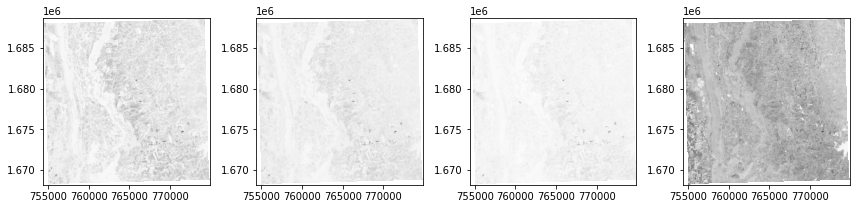

In [ ]:
# Working with raster data
import rasterio
import matplotlib.pyplot as plt

# Open image files
B_dataset = rasterio.open('/content/drive/MyDrive/gdrive/MyDrive/sentinel-2-image/2021/20210106/IMG_DATA/47PQS_20210106_B02.jp2', driver='JP2OpenJPEG')
G_dataset = rasterio.open('/content/drive/MyDrive/gdrive/MyDrive/sentinel-2-image/2021/20210106/IMG_DATA/47PQS_20210106_B03.jp2', driver='JP2OpenJPEG')
R_dataset = rasterio.open('/content/drive/MyDrive/gdrive/MyDrive/sentinel-2-image/2021/20210106/IMG_DATA/47PQS_20210106_B04.jp2', driver='JP2OpenJPEG')
NIR_dataset = rasterio.open('/content/drive/MyDrive/gdrive/MyDrive/sentinel-2-image/2021/20210106/IMG_DATA/47PQS_20210106_B08.jp2', driver='JP2OpenJPEG')

#multiple band representation
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(12, 4))
plot.show(R_dataset, ax=ax1, cmap='Greys')
plot.show(G_dataset, ax=ax2, cmap='Greys')
plot.show(B_dataset, ax=ax3, cmap='Greys')
plot.show(NIR_dataset, ax=ax4, cmap='Greys')
fig.tight_layout()

In [ ]:
#export true color image
S2_stack = rasterio.open('/content/drive/MyDrive/Hackathon/test_rgb.tiff','w',driver='Gtiff',
                         width=B_dataset.width, height=B_dataset.height,
                         count=4,
                         crs=B_dataset.crs,
                         transform=B_dataset.transform,
                         dtype=B_dataset.dtypes[0]
                         )
S2_stack.write(B_dataset.read(1),1) #blue
S2_stack.write(G_dataset.read(1),2) #green
S2_stack.write(R_dataset.read(1),3) #red
S2_stack.write(NIR_dataset.read(1),4) #red
S2_stack.close()

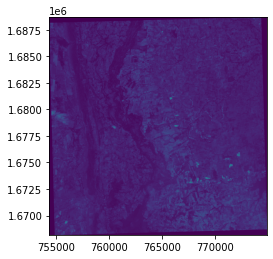

In [ ]:
src = rasterio.open(r"/content/drive/MyDrive/Hackathon/test_rgb.tiff", count=2)
plot.show(src)

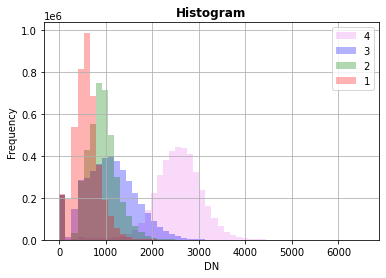

In [ ]:
plot.show_hist(src, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

# **Setup Vector**

In [ ]:
# read in training data polygons that created as geojson from a shared directory
training_data = '/content/drive/MyDrive/Hackathon/geojson/traindata.geojson'
training_vectors = gpd.read_file(training_data)

In [ ]:
# make a bounding box and centroid for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

# show the 1st 5 lines
training_vectors.head()

len(training_vectors)

# find all unique values of training data names to use as classes
classes = np.unique(training_vectors.crop_type)
print(classes)


# create a dictionary to convert class names into integers for modeling
class_dict = dict(zip(classes, range(len(classes))))
print(class_dict)    

print(len(training_vectors))

['1' '2' '3' '4']
{'1': 0, '2': 1, '3': 2, '4': 3}
1317


# **Prepare Raster**

In [ ]:
##If you want to read the data directly from the shared folder, uncomment the following line.
raster_file = '/content/drive/MyDrive/Hackathon/test_rgb.tiff'

full_dataset = rasterio.open(raster_file)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands
print(full_dataset.crs)

(2051, 2051)
4
EPSG:32647


# **Prepare Vector**

In [ ]:
# raster information
# a custom function for getting each value from the raster
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.crop_type, training_vectors.geometry): #####
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='float',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])

In [ ]:
# convert the training data lists into the appropriate numpy array shape and format for scikit-learn
X = np.array(X_raw)
y = np.array(y_raw)
print(X.shape, y.shape)
print(type(X), type(y))

(285040, 4) (285040,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [57]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = np.ravel(y)
y.reshape(-1)

array([0, 0, 0, ..., 2, 2, 2])

# **Split Data**

In [60]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [61]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 1.3909947003101918e-05,
 1: 4.5547711227510815e-05,
 2: 1.659062629614268e-05,
 3: 5.916109566349169e-05}

In [62]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(171024, 4)
(114016, 4)
(171024,)
(114016,)


# **Machine Learning**

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
########################################################
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
########################################################
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image
import sklearn

In [64]:
RF_model = RandomForestClassifier()
MLP_model = MLPClassifier()
XGB_model = XGBClassifier()

In [65]:
RF_model.fit(X_train, y_train)
MLP_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


XGBClassifier(objective='multi:softprob')

In [66]:
RF_prediction = RF_model.predict(X_test)
MLP_prediction = MLP_model.predict(X_test)
XGB_prediction = XGB_model.predict(X_test)

# **Performance**

In [67]:
RF_accuracy = accuracy_score(RF_prediction, y_test)
print("Accuracy: %.2f%%" % (RF_accuracy * 100.0))
print(classification_report(RF_prediction, y_test))
print(confusion_matrix(RF_prediction, y_test))

Accuracy: 50.85%
              precision    recall  f1-score   support

           0       0.63      0.54      0.58     55249
           1       0.32      0.46      0.38     10351
           2       0.52      0.49      0.50     42314
           3       0.23      0.42      0.29      6102

    accuracy                           0.51    114016
   macro avg       0.42      0.48      0.44    114016
weighted avg       0.54      0.51      0.52    114016

[[29826  5352 16277  3794]
 [ 2279  4713  2034  1325]
 [14199  3699 20890  3526]
 [ 1359   912  1282  2549]]


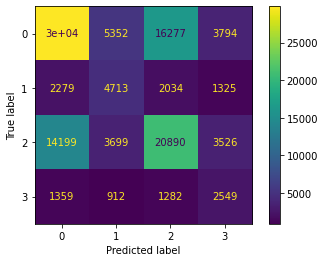

In [68]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(RF_prediction, y_test),display_labels=RF_model.classes_)
disp.plot()
plt.show()

In [69]:
MLP_accuracy = accuracy_score(MLP_prediction, y_test)
print("Accuracy: %.2f%%" % (MLP_accuracy * 100.0))
print(classification_report(MLP_prediction, y_test))
print(confusion_matrix(MLP_prediction, y_test))

Accuracy: 51.01%
              precision    recall  f1-score   support

           0       0.59      0.56      0.57     50437
           1       0.30      0.47      0.37      9515
           2       0.58      0.47      0.52     49968
           3       0.17      0.47      0.25      4096

    accuracy                           0.51    114016
   macro avg       0.41      0.49      0.43    114016
weighted avg       0.55      0.51      0.52    114016

[[28144  4845 14454  2994]
 [ 2000  4470  1677  1368]
 [16813  4656 23608  4891]
 [  706   705   744  1941]]


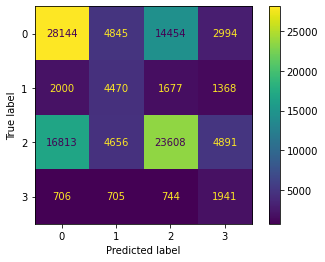

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(MLP_prediction, y_test),display_labels=MLP_model.classes_)
disp.plot()
plt.show()

In [71]:
XGB_accuracy = accuracy_score(XGB_prediction, y_test)
print("Accuracy: %.2f%%" % (XGB_accuracy * 100.0))
print(classification_report(XGB_prediction, y_test))
print(confusion_matrix(XGB_prediction, y_test))

Accuracy: 50.01%
              precision    recall  f1-score   support

           0       0.65      0.53      0.58     58689
           1       0.28      0.46      0.35      9022
           2       0.50      0.47      0.49     42969
           3       0.15      0.50      0.23      3336

    accuracy                           0.50    114016
   macro avg       0.39      0.49      0.41    114016
weighted avg       0.55      0.50      0.52    114016

[[30975  5978 17843  3893]
 [ 1905  4108  1727  1282]
 [14268  4059 20279  4363]
 [  515   531   634  1656]]


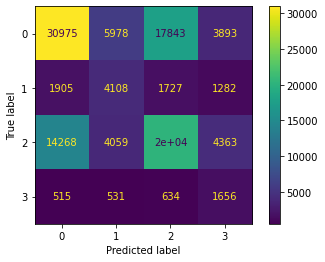

In [72]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(XGB_prediction, y_test),display_labels=XGB_model.classes_)
disp.plot()
plt.show()

# **Deep Learning**

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
########################################################
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import metrics
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.2
Num GPUs Available:  1


In [73]:
print(X_train.shape)
print(X_test.shape)

(171024, 4)
(114016, 4)


In [74]:
nrows, ncols = X_train.shape
nrows1, ncols1 = X_test.shape
X_train_re = X_train.reshape(nrows, ncols, 1)
X_test_re = X_test.reshape(nrows1, ncols1, 1)
print(X_train_re.shape)
print(X_test_re.shape)

(171024, 4, 1)
(114016, 4, 1)


In [75]:
model_RNN = tf.keras.Sequential()
#model_RNN.add(tf.keras.layers.SimpleRNN(10,return_sequences= True)),
model_RNN.add(tf.keras.layers.SimpleRNN(10)),
model_RNN.add(tf.keras.layers.Dense(4, activation='softmax'))

In [76]:
model_RNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [77]:
model_RNN.build(X_train_re.shape)

In [78]:
print(model_RNN.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (171024, 10)              120       
                                                                 
 dense_2 (Dense)             (171024, 4)               44        
                                                                 
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# Fit model  
epochs = 100            
history_RNN = model_RNN.fit(X_train, y_train,epochs=epochs, batch_size=128,validation_split = 0.2, shuffle=True)

Epoch 1/100


InvalidArgumentError: ignored

In [ ]:
# list all data in history
print(history_RNN.history.keys())

In [ ]:
acc = history_RNN.history['accuracy']
val_acc = history_RNN.history['val_accuracy']

loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()